Our dataset is provided by GroupLens and can be found [here](https://grouplens.org/datasets/movielens/). We will be using the latest small and full datasets.

In [81]:
library(tidyverse)
library(ggthemes)
library(lubridate)
library(stringr)
library(wordcloud)
library(recommenderlab)
library(reshape2)

theme_set(theme_bw())
theme_update(plot.title = element_text(hjust = 0.5))

In [2]:
dataset_files <- c("movies", "ratings", "links", "tags")
dataset_small <- "ml-latest-small"
dataset_full <- "ml-latest"
dataset <- dataset_full
data_folder <- "data"
suffix <- ".csv"

for (f in dataset_files) {
  path <- file.path(data_folder, dataset, paste0(f, suffix))
  assign(f, read_csv(path))
  print(paste(f, "object size is", format(object.size(get(f)),units="Mb")))
}

Parsed with column specification:
cols(
  movieId = col_integer(),
  title = col_character(),
  genres = col_character()
)


[1] "movies object size is 4.3 Mb"


Parsed with column specification:
cols(
  userId = col_integer(),
  movieId = col_integer(),
  rating = col_double(),
  timestamp = col_integer()
)


[1] "ratings object size is 496.4 Mb"


Parsed with column specification:
cols(
  movieId = col_integer(),
  imdbId = col_character(),
  tmdbId = col_integer()
)


[1] "links object size is 2.8 Mb"


Parsed with column specification:
cols(
  userId = col_integer(),
  movieId = col_integer(),
  tag = col_character(),
  timestamp = col_integer()
)


[1] "tags object size is 17.5 Mb"


In [3]:
glimpse(ratings)

Observations: 26,024,289
Variables: 4
$ userId    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ movieId   <int> 110, 147, 858, 1221, 1246, 1968, 2762, 2918, 2959, 4226, ...
$ rating    <dbl> 1.0, 4.5, 5.0, 5.0, 5.0, 4.0, 4.5, 5.0, 4.0, 4.0, 5.0, 5....
$ timestamp <int> 1425941529, 1425942435, 1425941523, 1425941546, 142594155...


In [4]:
ratings <- ratings %>%
  mutate(timestamp = as_datetime(timestamp))

In [5]:
glimpse(ratings)

Observations: 26,024,289
Variables: 4
$ userId    <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ movieId   <int> 110, 147, 858, 1221, 1246, 1968, 2762, 2918, 2959, 4226, ...
$ rating    <dbl> 1.0, 4.5, 5.0, 5.0, 5.0, 4.0, 4.5, 5.0, 4.0, 4.0, 5.0, 5....
$ timestamp <dttm> 2015-03-09 22:52:09, 2015-03-09 23:07:15, 2015-03-09 22:...


In [6]:
glimpse(movies)

Observations: 45,843
Variables: 3
$ movieId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ title   <chr> "Toy Story (1995)", "Jumanji (1995)", "Grumpier Old Men (19...
$ genres  <chr> "Adventure|Animation|Children|Comedy|Fantasy", "Adventure|C...


In [7]:
movies <- movies %>%
  # trim whitespaces
  mutate(title = str_trim(title)) %>%
  # split title to title, year
  extract(title, c("title_tmp", "year"), regex = "^(.*) \\(([0-9 \\-]*)\\)$", remove = F) %>%
  # for series take debut date
  mutate(year = if_else(str_length(year) > 4, as.integer(str_split(year, "-", simplify = T)[1]), as.integer(year))) %>%
  # replace title NA's with original title
  mutate(title = if_else(is.na(title_tmp), title, title_tmp)) %>%
  # drop title_tmp column
  select(-title_tmp)  %>%
  # generic function to turn (no genres listed) to NA
  mutate(genres = if_else(genres == "(no genres listed)", `is.na<-`(genres), genres))

In [8]:
head(movies)

movieId,title,year,genres
1,Toy Story,1995,Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji,1995,Adventure|Children|Fantasy
3,Grumpier Old Men,1995,Comedy|Romance
4,Waiting to Exhale,1995,Comedy|Drama|Romance
5,Father of the Bride Part II,1995,Comedy
6,Heat,1995,Action|Crime|Thriller


In [9]:
nrow(movies %>%
  filter(is.na(title) | is.na(year)))

[1] 196

In [10]:
glimpse(tags)

Observations: 753,170
Variables: 4
$ userId    <int> 1, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 49...
$ movieId   <int> 318, 4306, 89302, 89302, 89302, 89302, 96079, 113315, 113...
$ tag       <chr> "narrated", "Dreamworks", "England", "espionage", "jazz",...
$ timestamp <int> 1425942391, 1459855607, 1400778834, 1400778836, 140077884...


In [11]:
tags <- tags %>%
  mutate(timestamp = as_datetime(timestamp))

In [12]:
glimpse(tags)

Observations: 753,170
Variables: 4
$ userId    <int> 1, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 49, 49...
$ movieId   <int> 318, 4306, 89302, 89302, 89302, 89302, 96079, 113315, 113...
$ tag       <chr> "narrated", "Dreamworks", "England", "espionage", "jazz",...
$ timestamp <dttm> 2015-03-09 23:06:31, 2016-04-05 11:26:47, 2014-05-22 17:...


# How many movies were produced per year?

In [13]:
movies_per_year <- movies %>%
  na.omit() %>% # omit missing values
  select(movieId, year) %>% # select columns we need
  group_by(year) %>% # group by year
  summarise(count = n())  %>% # count movies per year
  arrange(year)

In [14]:
head(movies_per_year)

year,count
1874,1
1888,2
1890,1
1891,4
1892,1
1894,12


In [15]:
# fill missing years

movies_per_year <- movies_per_year %>%
  complete(year = full_seq(year, 1), fill = list(count = 0))

In [16]:
head(movies_per_year)

year,count
1874,1
1875,0
1876,0
1877,0
1878,0
1879,0


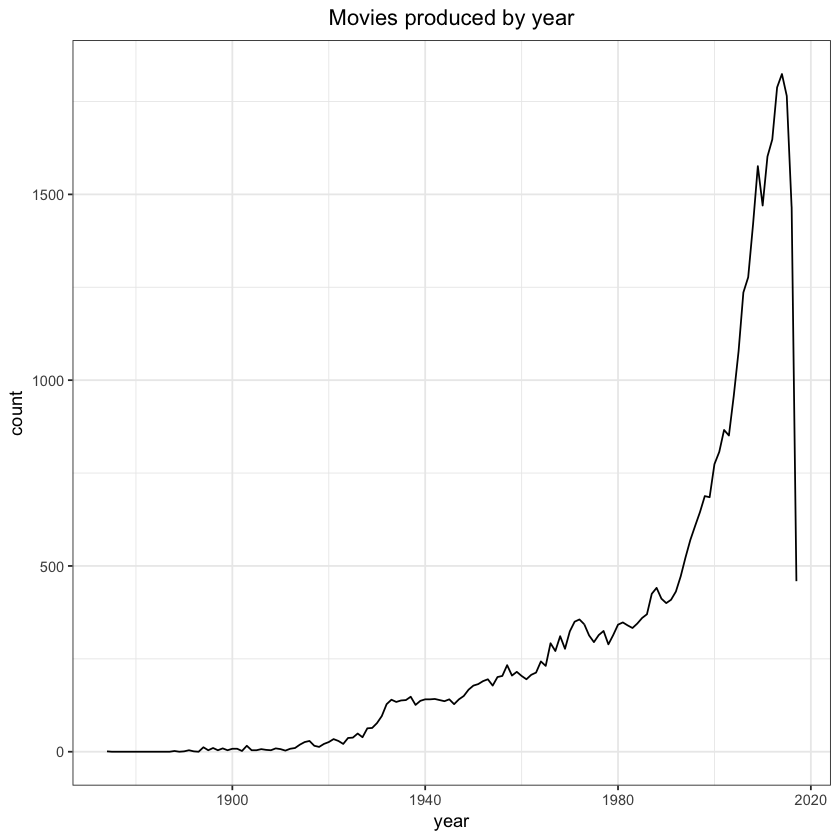

In [17]:
movies_per_year %>%
    ggplot(aes(x = year, y = count)) +
    geom_line() +
    ggtitle("Movies produced by year")

# What genres were popular during the years?

In [18]:
genres <- movies %>%
  separate_rows(genres, sep = "\\|") %>%
  group_by(genres) %>%
  summarise(number = n()) %>%
  arrange(desc(number))

In [19]:
head(genres, 10)

genres,number
Drama,19806
Comedy,13002
Thriller,6761
Romance,6069
Action,5775
Horror,4448
Crime,4247
Documentary,4122
Adventure,3369
Sci-Fi,2847


In [20]:
genres_popularity_per_year <- movies %>%
  na.omit() %>% # omit missing values
  select(movieId, year, genres) %>% # select columns we are interested in
  separate_rows(genres, sep = "\\|") %>% # separate genres into rows
  mutate(genres = as.factor(genres)) %>% # turn genres in factors
  group_by(year, genres) %>% # group data by year and genre
  summarise(number = n()) %>% # count
  complete(year = full_seq(year, 1), genres, fill = list(number = 0)) # add missing years/genres

In [21]:
head(genres_popularity_per_year)

year,genres,number
1874,Action,0
1874,Adventure,0
1874,Animation,0
1874,Children,0
1874,Comedy,0
1874,Crime,0


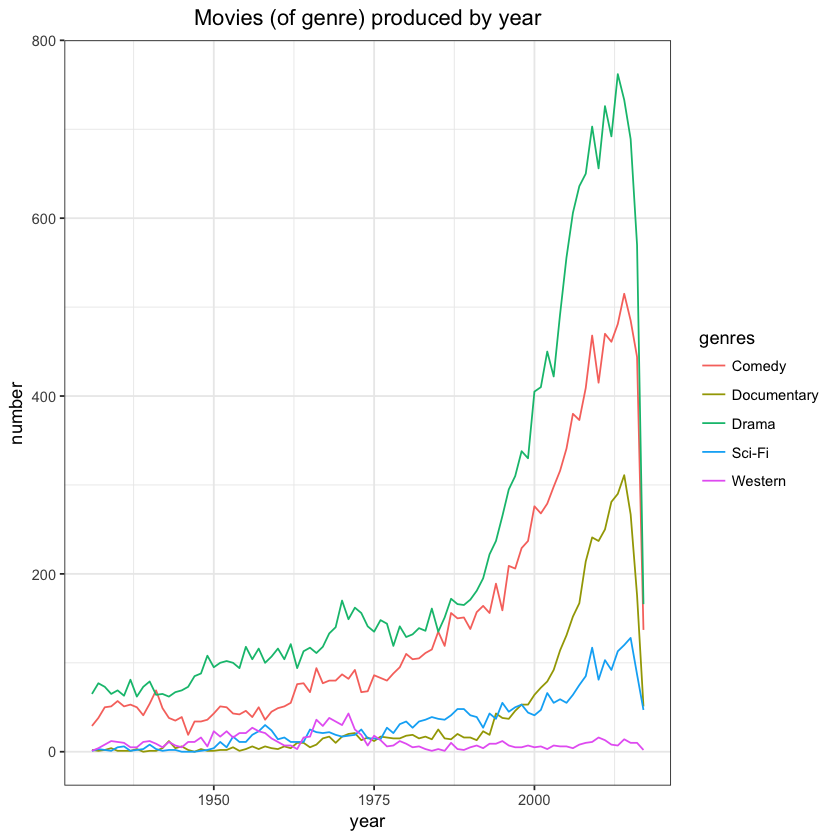

In [22]:
genres_popularity_per_year %>%
  filter(year > 1930) %>%
  filter(genres %in% c("Drama", "Comedy", "Western", "Sci-Fi", "Documentary")) %>%
  ggplot(aes(x = year, y = number)) +
    geom_line(aes(color=genres)) +
    ggtitle("Movies (of genre) produced by year")

# What tags summarize a specific movie genre?

In [23]:
genres_tags <- movies %>%
  na.omit() %>%
  select(movieId, year, genres) %>%
  separate_rows(genres, sep = "\\|") %>%
  inner_join(tags, by = "movieId") %>%
  select(genres, tag) %>%
  group_by(genres) %>%
  nest()

In [24]:
genre <- "Drama"

genre_words <- genres_tags %>%
  filter(genres == genre) %>%
  unnest() %>%
  mutate(tag = str_to_lower(tag, "en")) %>%
  anti_join(tibble(tag=c(tolower(genre)))) %>%
  count(tag)

Joining, by = "tag"


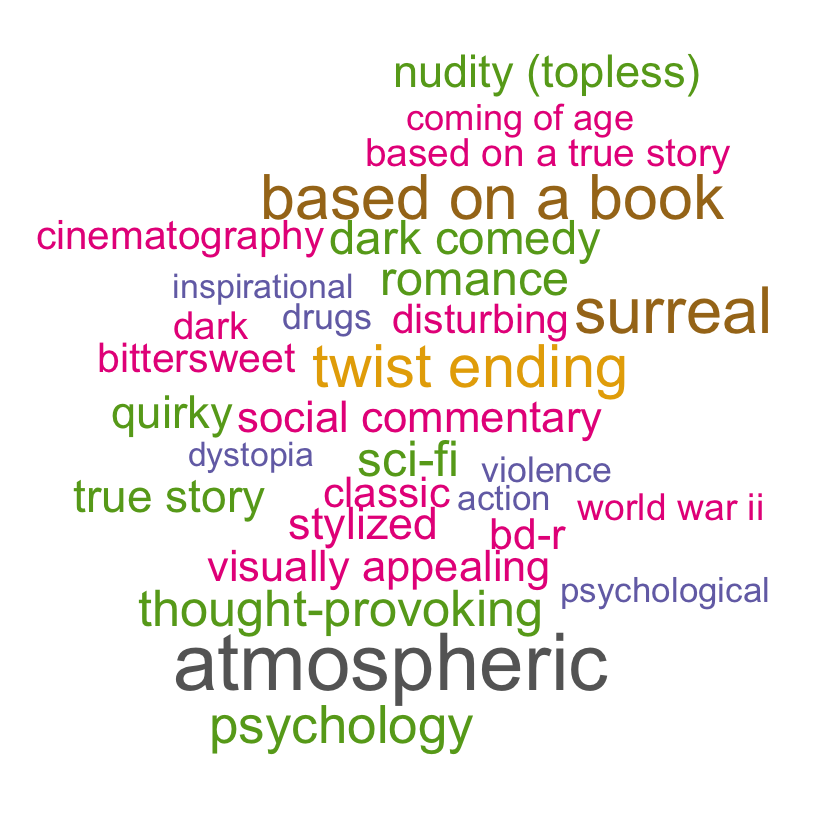

In [25]:
wordcloud(genre_words$tag, genre_words$n, max.words = 30, colors=brewer.pal(8, "Dark2"))

# What are the highest rated movies for every decade?

In [26]:
avg_rating <- ratings %>%
  inner_join(movies, by = "movieId") %>%
  na.omit() %>%
  select(movieId, title, rating, year) %>%
  group_by(movieId, title, year) %>%
  summarise(count = n(), mean = mean(rating), min = min(rating), max = max(rating)) %>%
  ungroup() %>%
  arrange(desc(mean))

In [27]:
head(avg_rating, 10)

movieId,title,year,count,mean,min,max
27396,"Gentleman's Game, A",2002,1,5,5,5
27914,"Hijacking Catastrophe: 9/11, Fear & the Selling of American Empire",2004,1,5,5,5
66389,AmericanEast,2008,1,5,5,5
90464,"Frozen North, The",2006,2,5,5,5
92783,Latin Music USA,2009,1,5,5,5
93967,"Keeping the Promise (Sign of the Beaver, The)",1997,1,5,5,5
94972,"Best of Ernie and Bert, The",1988,1,5,5,5
95517,"Barchester Chronicles, The",1982,3,5,5,5
95977,Junior Prom,1946,1,5,5,5
98437,Bed of Roses,1933,1,5,5,5


That doesn't seem right. Let's try again using the IMDB weighted average rating:

In [28]:
# R = average for the movie (mean) = (Rating)
# v = number of votes for the movie = (votes)
# m = minimum votes required to be listed in the Top 250
# C = the mean vote across the whole report
weighted_rating <- function(R, v, m, C) {
  return (v/(v+m))*R + (m/(v+m))*C
}

In [29]:
avg_rating <- avg_rating %>%
  mutate(wr = weighted_rating(mean, count, 500, mean(mean))) %>%
  arrange(desc(wr))

In [30]:
head(avg_rating)

movieId,title,year,count,mean,min,max,wr
356,Forrest Gump,1994,91921,4.052926,0.5,5,0.9945900
318,"Shawshank Redemption, The",1994,91082,4.429015,0.5,5,0.9945404
296,Pulp Fiction,1994,87901,4.169975,0.5,5,0.9943440
593,"Silence of the Lambs, The",1991,84078,4.152246,0.5,5,0.9940883
2571,"Matrix, The",1999,77960,4.154098,0.5,5,0.9936273
260,Star Wars: Episode IV - A New Hope,1977,77045,4.132299,0.5,5,0.9935521


In [31]:
best_per_decade <- avg_rating %>%
  mutate(decade = year  %/% 10 * 10) %>%
  arrange(year, desc(wr)) %>%
  group_by(decade) %>%
  summarise(
      title = first(title), 
      year = first(year), 
      wr = first(wr), 
      mean = first(mean), 
      count = first(count)
  )

In [32]:
best_per_decade

decade,title,year,wr,mean,count
1870,Passage de Venus,1874,0.01768173,2.388889,9
1880,Traffic Crossing Leeds Bridge,1888,0.01768173,2.333333,9
1890,"Monkeyshines, No. 1",1890,0.01185771,1.583333,6
1900,The Kiss,1900,0.02534113,3.153846,13
1910,Frankenstein,1910,0.04761905,3.180000,25
1920,"Cabinet of Dr. Caligari, The (Cabinet des Dr. Caligari., Das)",1920,0.77283053,3.897707,1701
1930,All Quiet on the Western Front,1930,0.85043374,3.932642,2843
1940,Pinocchio,1940,0.96872068,3.447594,15485
1950,Cinderella,1950,0.95640042,3.542715,10968
1960,Psycho,1960,0.97889227,4.065206,23188


# What is the average rating for a movie?

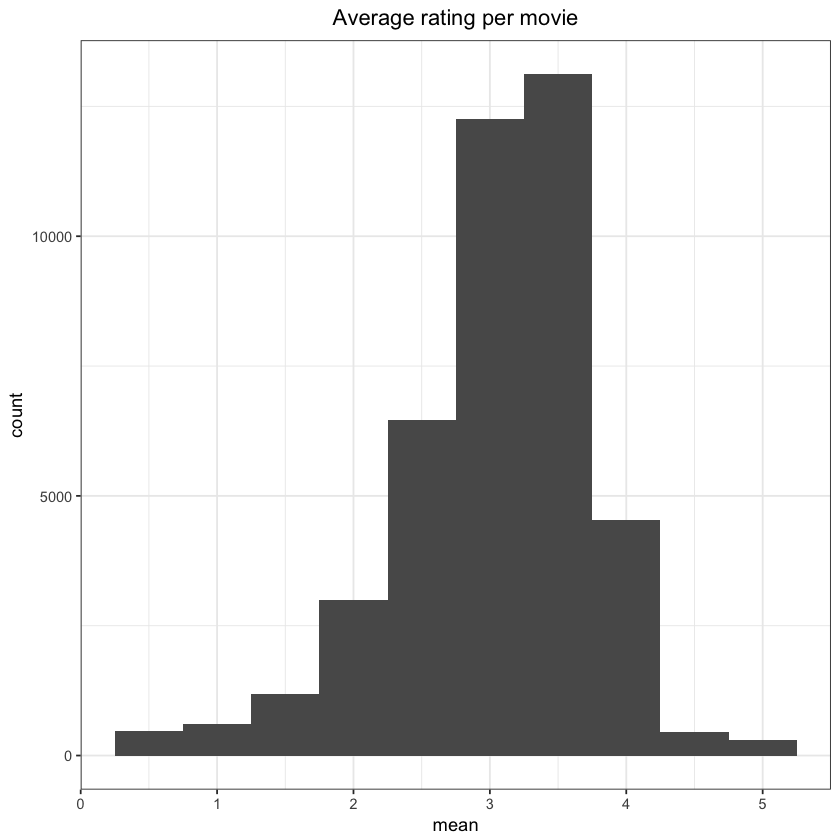

In [33]:
avg_rating %>% 
    ggplot(aes(mean)) + 
    geom_histogram(binwidth = 0.5) +
    ggtitle("Average rating per movie")

# How many movies users are rating?

In [34]:
head(ratings)

userId,movieId,rating,timestamp
1,110,1.0,2015-03-09 22:52:09
1,147,4.5,2015-03-09 23:07:15
1,858,5.0,2015-03-09 22:52:03
1,1221,5.0,2015-03-09 22:52:26
1,1246,5.0,2015-03-09 22:52:36
1,1968,4.0,2015-03-09 23:02:28


In [35]:
ratings_per_user <- ratings %>%
    group_by(userId) %>%
    summarise(count = n()) %>%
    arrange(desc(count))

In [36]:
head(ratings_per_user)

userId,count
45811,18276
8659,9279
270123,7638
179792,7515
228291,7410
243443,6320


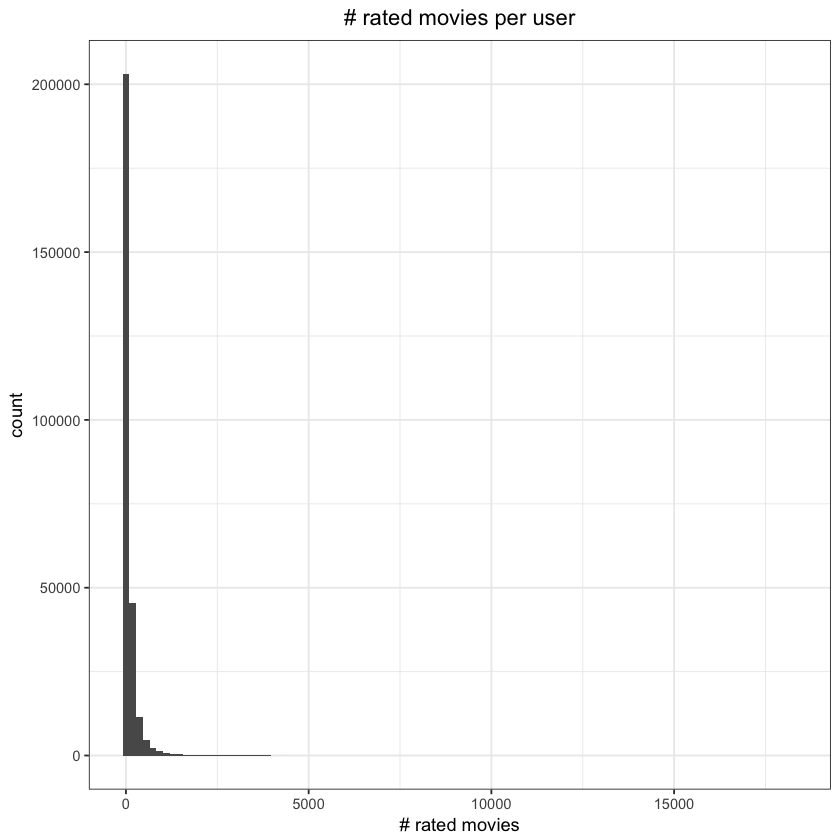

In [37]:
ratings_per_user %>% 
    ggplot(aes(count)) + 
    geom_histogram(bins=100) +
    xlab("# rated movies") +
    ggtitle("# rated movies per user")

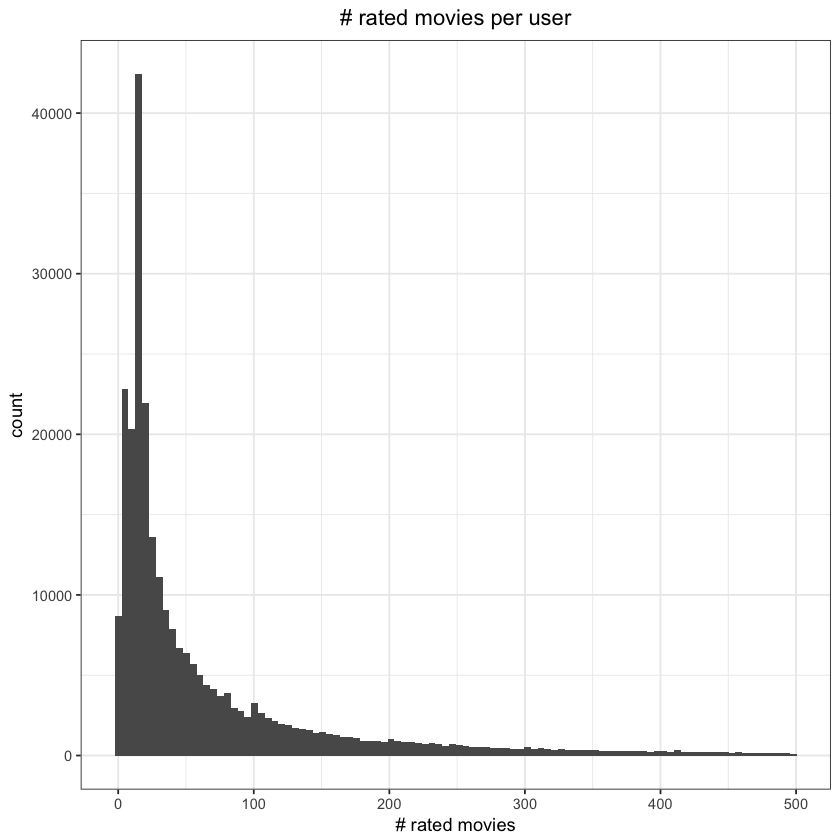

In [38]:
ratings_per_user %>%
    filter(count < 500) %>%
    ggplot(aes(count)) + 
    geom_histogram(bins=100) +
    xlab("# rated movies") +
    ggtitle("# rated movies per user")

# Building a Movie Recommender

In [39]:
movies_small <- read_csv("data/ml-latest-small/movies.csv")
ratings_small <- read_csv("data/ml-latest-small/ratings.csv")

Parsed with column specification:
cols(
  movieId = col_integer(),
  title = col_character(),
  genres = col_character()
)
Parsed with column specification:
cols(
  userId = col_integer(),
  movieId = col_integer(),
  rating = col_double(),
  timestamp = col_integer()
)


In [40]:
ratings_matrix <-
  dcast(ratings_small,
        userId ~ movieId,
        value.var = "rating",
        na.rm = FALSE)

In [41]:
head(ratings_matrix)

userId,1,2,3,4,5,6,7,8,9,⋯,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,NA,NA,4,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [42]:
ratings_matrix <- as.matrix(ratings_matrix[, -1])

In [43]:
head(ratings_matrix)

1,2,3,4,5,6,7,8,9,10,⋯,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,4,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [44]:
ratings_matrix <- as(ratings_matrix, "realRatingMatrix")

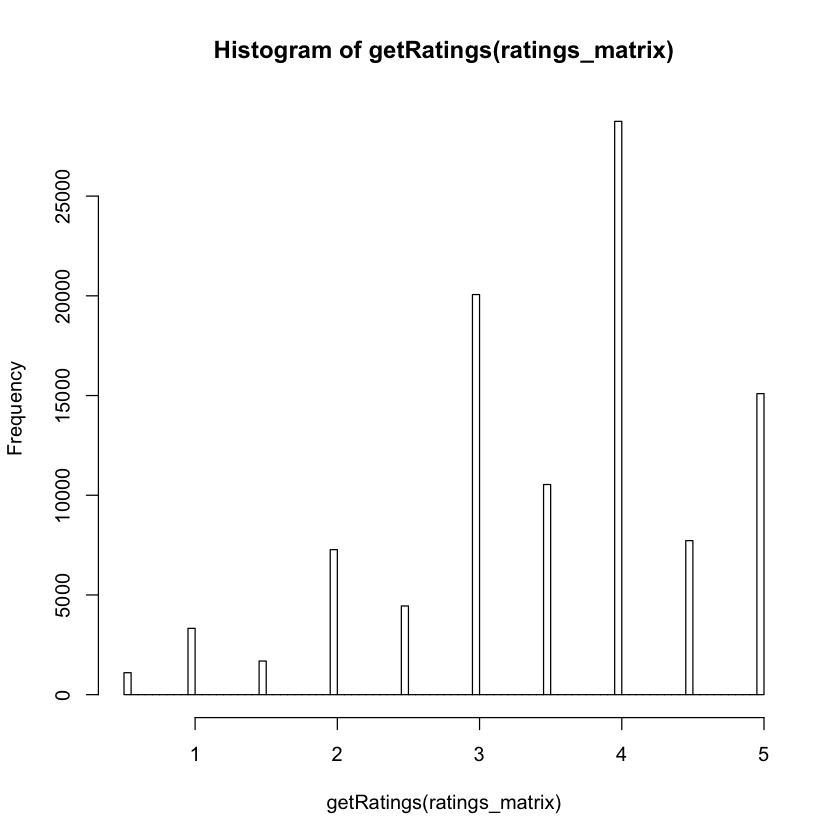

In [45]:
hist(getRatings(ratings_matrix), breaks="FD")

Some users consistently give high (or low) ratings to all movies they watch. We can try to remove this effect by normalizing our data in such a way that the average rating of each user is 0. This seems to be 

In [46]:
ratings_norm <- normalize(ratings_matrix)

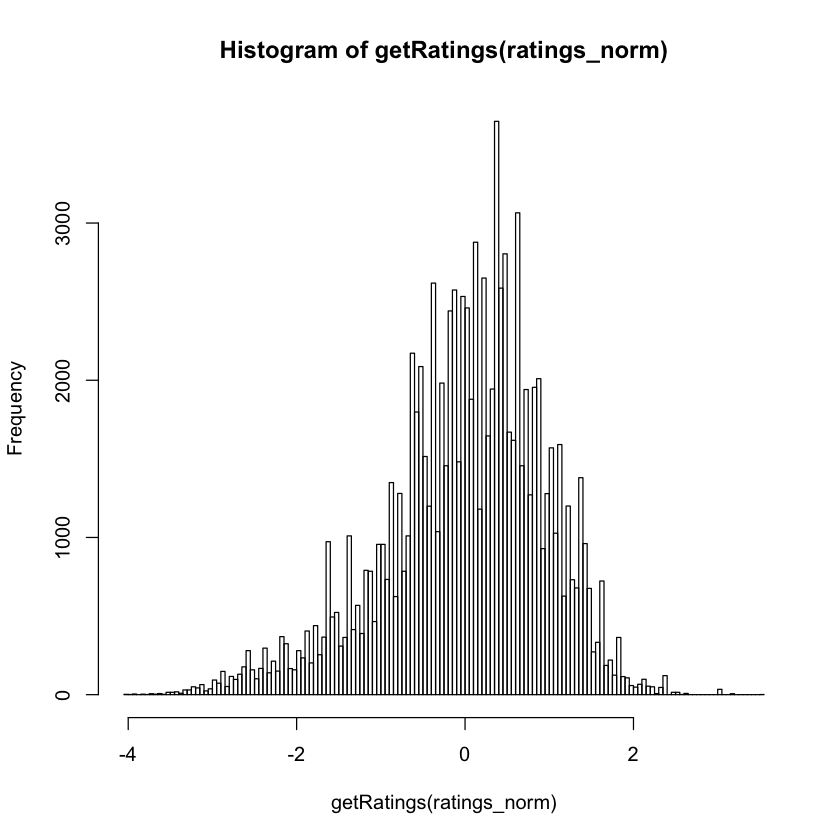

In [47]:
hist(getRatings(ratings_norm), breaks="FD")

# Making a model & evaluation

In [55]:
evaluation_scheme <- evaluationScheme(
    ratings_matrix,
    method = "cross-validation",
    k = 5,
    given = 3,
    goodRating = 5
)

algorithms <- list(
    "random items" = list(name = "RANDOM", param = NULL),
    "popular items" = list(name = "POPULAR", param = NULL),
    "user-based CF (cosine)" = list(
        name = "UBCF", 
        param = list(
            method = "Cosine",
            nn = 40
        )
    ),
    "user-based CF (pearson)" = list(
        name = "UBCF", 
        param = list(
            method = "Pearson",
            nn = 40
        )
    )
)

In [58]:
eval_results <-
  evaluate(evaluation_scheme, 
           algorithms, 
           n = c(1, 3, 5, 10, 15, 20) # top 1, 3, 5 etc recommendations
          )

RANDOM run fold/sample [model time/prediction time]
	 1  [0.002sec/1.245sec] 
	 2  [0.001sec/1.203sec] 
	 3  [0.002sec/1.186sec] 
	 4  [0.001sec/1.195sec] 
	 5  [0.001sec/1.157sec] 
POPULAR run fold/sample [model time/prediction time]
	 1  [0.011sec/1.168sec] 
	 2  [0.012sec/1.13sec] 
	 3  [0.009sec/1.133sec] 
	 4  [0.01sec/1.18sec] 
	 5  [0.011sec/1.181sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.008sec/3.195sec] 
	 2  [0.007sec/3.174sec] 
	 3  [0.007sec/3.159sec] 
	 4  [0.007sec/3.2sec] 
	 5  [0.009sec/3.178sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.007sec/1.262sec] 
	 2  [0.007sec/1.304sec] 
	 3  [0.007sec/1.153sec] 
	 4  [0.006sec/1.214sec] 
	 5  [0.007sec/1.357sec] 


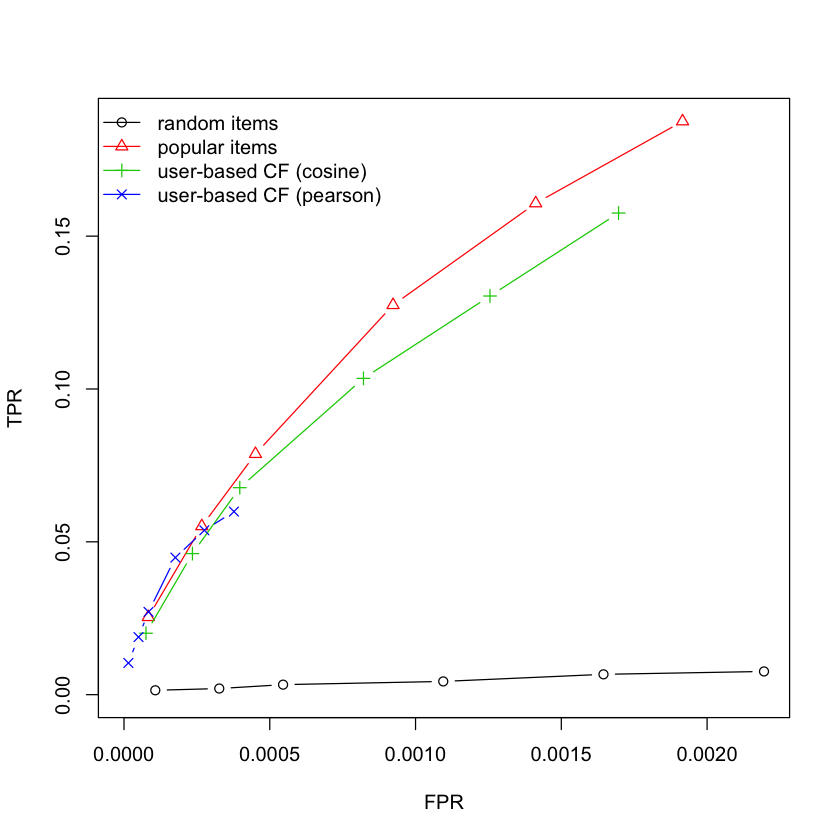

In [62]:
plot(eval_results, legend = "topleft")

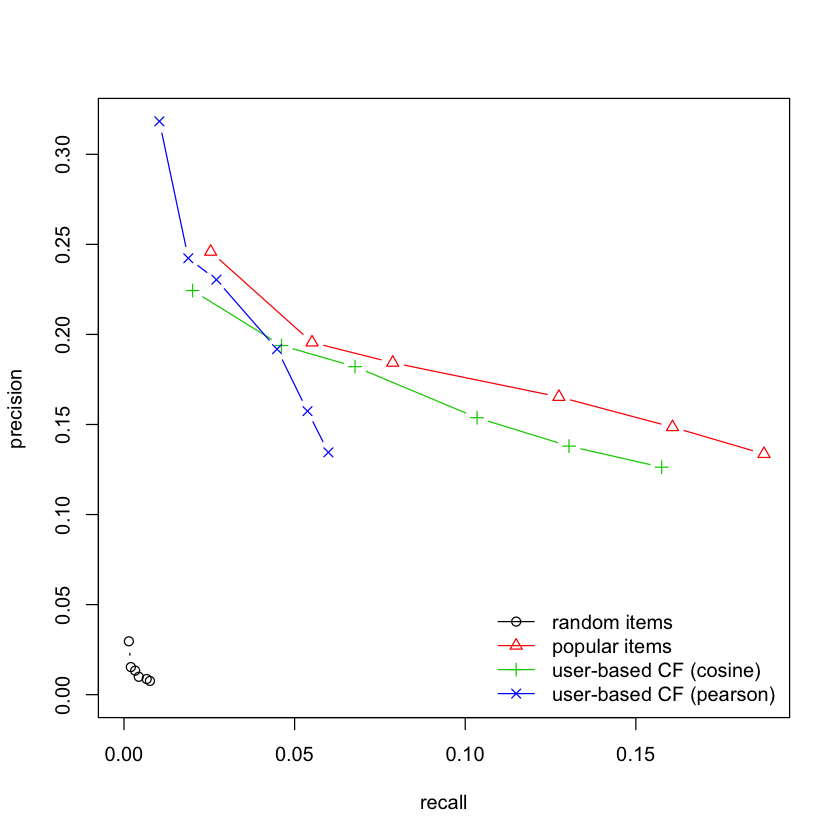

In [63]:
plot(eval_results, "prec/rec")

In [80]:
avg(eval_results[[3]])

,TP,FP,FN,TN,precision,recall,TPR,FPR
1,0.1970370,0.6814815,21.69926,9040.422,0.2243732,0.02009680,0.02009680,7.534292e-05
3,0.5125926,2.1229630,21.38370,9038.981,0.1938522,0.04615108,0.04615108,2.347097e-04
5,0.8000000,3.5925926,21.09630,9037.511,0.1821169,0.06770922,0.06770922,3.971764e-04
10,1.3555556,7.4296296,20.54074,9033.674,0.1537645,0.10346591,0.10346591,8.213730e-04
15,1.8237037,11.3540741,20.07259,9029.750,0.1379889,0.13041472,0.13041472,1.255269e-03
20,2.2266667,15.3437037,19.66963,9025.760,0.1262886,0.15755382,0.15755382,1.696402e-03


# Making predictions

In [69]:
model <- Recommender(
    ratings_matrix, 
    method = "UBCF", 
    param = list(
        normalize = "center",
        method = "Cosine", 
        nn = 30
    )
)

Let's recommend new movies for the 1st user: 

In [70]:
user_ratings <- as(ratings_matrix[1, ], "list")[[1]]

In [71]:
d <- as_tibble(user_ratings)
d$movieId = as.integer(rownames(d))
colnames(d) <- c("rating", "movieId")
rownames(d) <- NULL

In [73]:
d %>%
    inner_join(movies, by = "movieId")

rating,movieId,title,year,genres
2.5,31,Dangerous Minds,1995,Drama
3.0,1029,Dumbo,1941,Animation|Children|Drama|Musical
3.0,1061,Sleepers,1996,Thriller
2.0,1129,Escape from New York,1981,Action|Adventure|Sci-Fi|Thriller
4.0,1172,Cinema Paradiso (Nuovo cinema Paradiso),1989,Drama
2.0,1263,"Deer Hunter, The",1978,Drama|War
2.0,1287,Ben-Hur,1959,Action|Adventure|Drama
2.0,1293,Gandhi,1982,Drama
3.5,1339,Dracula (Bram Stoker's Dracula),1992,Fantasy|Horror|Romance|Thriller
2.0,1343,Cape Fear,1991,Thriller


In [74]:
predictions <- predict(model, ratings_matrix[1], n = 10)

In [75]:
recommendations <- predictions@items[[1]]

In [76]:
recom_result <- as.data.frame(movies[recommendations, ])

In [77]:
recom_result

movieId,title,year,genres
539,Sleepless in Seattle,1993,Comedy|Drama|Romance
3962,Ghoulies II,1987,Comedy|Horror
5112,Last Orders,2001,Drama
325,National Lampoon's Senior Trip,1995,Comedy
4485,Casual Sex?,1988,Comedy
131,Frankie Starlight,1995,Drama|Romance
2424,You've Got Mail,1998,Comedy|Romance
7003,Kafka,1991,Comedy|Drama|Mystery|Sci-Fi|Thriller
971,Cat on a Hot Tin Roof,1958,Drama
476,"Inkwell, The",1994,Comedy|Drama
